### All-sky AME vs. IR Scatter Plots

In [1]:
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import healpy.projector as pro
import astropy.io.fits as fits
from scipy.stats import gaussian_kde
import scipy
import pandas as pd
import pickle
matplotlib.style.use('seaborn-bright')
%matplotlib inline

In [2]:
with open('../Data/maps_nest.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw, phot, phot_modesub = pickle.load(f)
    
phot.head()


,A9,D12,I12,A18,D25,I25,D60,I60,A65,A90,D100,I100,D140,A140,A160,D240,P857,P545
0,34.855911,17.451921,38.151268,166.210815,31.467607,143.818436,176.029968,740.581726,841.084961,869.083191,468.836060,1028.531006,922.757690,1383.599487,1268.220337,622.031616,377.900726,109.778976
1,18.491539,17.259386,15.884996,20.741293,32.558685,28.891762,184.126022,123.698280,98.440353,237.669846,469.933502,374.433441,899.732056,752.598267,743.220398,597.903870,255.129669,77.916206
2,17.940084,14.711280,13.769882,18.158123,21.593317,22.371168,119.063034,90.925049,92.074516,208.284378,367.551971,308.790009,782.023987,699.684021,747.056213,541.778931,232.042496,72.071213
3,15.132369,14.003901,10.946995,16.280590,23.470364,18.745209,126.446312,70.853897,76.586433,165.872162,355.165710,242.223358,689.149109,568.832336,611.148804,473.048828,191.143707,60.399391
4,16.205063,13.605496,11.898948,16.947466,21.211246,19.663418,129.394897,87.902573,93.662560,207.240616,374.845215,288.520477,744.109009,635.620728,650.872498,508.054749,215.445648,67.946175


In [3]:
glatrange     = 10.0
glatrange_mid = 2.5
elatrange     = 10


gcut_l = np.where((abs(coords['glat']) < glatrange) & (abs(coords['elat']) > elatrange))
gcut_h = np.where((abs(coords['glat']) > glatrange) & (abs(coords['elat']) > elatrange))







In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


### Setup the standard pipeline to apply to all the data:
allsky_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler(with_mean=False)),
])
# allsky_pipeline = Pipeline([
#     ('imputer', Imputer(strategy="median"))
# ])

phot_tr = pd.DataFrame(allsky_pipeline.fit_transform(phot),columns=phot.columns)
planck_bb_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_bb),columns=planck_bb.columns)
planck_mw_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_mw),columns=planck_mw.columns)





In [14]:
phot_corr = phot_tr.corr(method='spearman')
planck_bb_corr = planck_bb_tr.corr(method='spearman')
planck_mw_corr = planck_mw_tr.corr(method='spearman')

In [15]:
import seaborn as sb
phot_corr     = phot_tr.join(planck_mw_tr['AME']).corr(method='spearman')
phot_corr_lgl = phot_tr.join(planck_mw_tr['AME']).iloc[gcut_l].corr(method='spearman')
phot_corr_hgl = phot_tr.join(planck_mw_tr['AME']).iloc[gcut_h].corr(method='spearman')

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


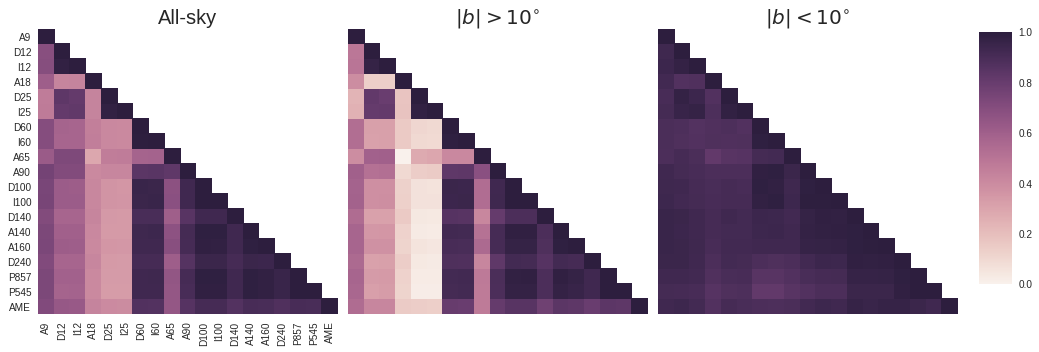

In [16]:
#bb_corr_drop = bb_corr.drop('AME',axis=0).drop('A9',axis=1)
mask = np.zeros_like(phot_corr.values)
mask[np.triu_indices_from(mask,k=1)] = True

with sb.axes_style("white"):

    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    cbar_ax = fig.add_axes([.91, .2, .03, .7])
    
    sb.heatmap(
        phot_corr,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=False,
        yticklabels=True,
        xticklabels=True,
        ax = ax[0],
        vmin=0,
        vmax=1)
    
    ax[0].set_title("All-sky", fontsize=20)

    
    sb.heatmap(
        phot_corr_hgl,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=False,
        yticklabels=False,
        xticklabels=False,
        ax=ax[1],
        vmin=0,
        vmax=1)
    
    ax[1].set_title("$|b| > 10^{\circ}$", fontsize=20)

    
    
    sb.heatmap(
        phot_corr_lgl,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=True,
        cbar_ax=cbar_ax,
        yticklabels=False,
        xticklabels=False,
        ax=ax[2],
        vmin=0,
        vmax=1)
    
    ax[2].set_title("$|b| < 10^{\circ}$", fontsize=20)


    fig.tight_layout(rect=[0, 0, .9, 1])
    
    plt.show()

    fig.savefig("../Plots/all_bands_corr_matrix_wAME_spearman.pdf", bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


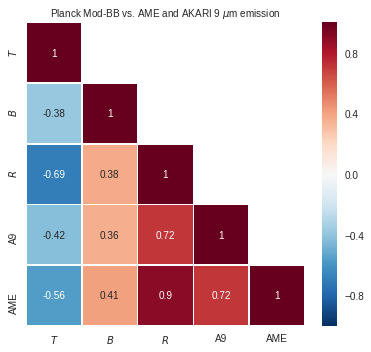

In [17]:
planck_bb_corr = planck_bb_tr.join(phot_tr['A9']).join(planck_mw_tr['AME']).corr(method='spearman')
#bb_corr_drop = bb_corr.drop('AME',axis=0).drop('A9',axis=1)
mask = np.zeros_like(planck_bb_corr.values)
mask[np.triu_indices_from(mask,k=1)] = True



with sb.axes_style("white"):
    
    fig = plt.figure(figsize=(6,5))
    sb.heatmap(
        planck_bb_corr,
        linewidths=.5,
        annot=True,
        mask=mask)
    
    
    fig.show()
    
    plt.title("Planck Mod-BB vs. AME and AKARI 9 $\mu$m emission",fontsize=10)
    
    fig.tight_layout(rect=[0, 0, .9, 1])

    fig.savefig("../Plots/PlanckModBBvsAMEandA9.pdf", bbox_inches='tight')
    


In [18]:
## Force background color to be white:
### Note that seaborn plotting functions my override these settings.
#plt.rcParams['axes.facecolor']='white'
#plt.rcParams['figure.facecolor']='white'
#plt.rcParams['savefig.facecolor']='white'

In [19]:
bba = planck_bb_tr.join(phot_tr['A9']).join(planck_mw_tr['AME'])

## Confirmation of all-sky correlation results:
# Instead of downgrading the pixel sizes, just copy the same correaltion value of the 64 NSIDE 256 pixels
# in a batch to all of those pixel positions in an output map (also size NSIDE 256).

In [20]:
#import pandas as pd
#import numpy as np
#import healpy as hp

def testSpatialCorr(df, nside_in, nside_out, test=False):
    
    npix_in    = 12*nside_in**2
    npix_out   = 12*nside_out**2
    pix_interv = (nside_in/nside_out)**2
    
    ## First, do it the "normal way"-
    patches_corr = [df.iloc[i*pix_interv:(i+1)*pix_interv].corr(method='spearman') for i in range(0,npix_out)]
    corr_patches_pn = pd.Panel({i: patches_corr[i] for i in range(0,npix_out)})

#     ## Confirm it:
#     if test==True:
        
#         patches_corr_conf = []

#         for i in range(0,npix_out):
#             for j in range(0,pix_interv):
#                 patches_corr_conf.append(patches_corr[i])

#         corr_patches_pn_conf = pd.Panel({i: patches_corr_conf[i] for i in range(0,npix_in)})

    fig = plt.figure(figsize=(8,4))

    for j in range(0,4):
        #plt.subplot(2,5,(j*2)+1)
        im = hp.cartview(corr_patches_pn.values[:,j,4],
                         sub=(1,4,j+1), 
                         fig=fig,
                         cmap="rainbow", 
                         cbar=True, 
                         min=-1, 
                         max=1, 
                         nest=True, 
                         title="$S$(AME:"+bba.columns[j]+") NSIDE"+str(nside_out))
        
        #fig.subplots_adjust(right=0.8)
        #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        #fig.colorbar(plt.gca(),cax=cbar_ax)
        plt.savefig("../Plots/Spearman_Map_nside"+str(nside_out)+"_AMEtoMBBandA9.pdf")
    
    return corr_patches_pn


In [ ]:
nside_in = 256
nside_out = 32
corr_patches_pn = testSpatialCorr(bba, nside_in, nside_out)

In [ ]:
nside_in = 256
nside_out = 16
corr_patches_pn = testSpatialCorr(bba, nside_in, nside_out,test=False)

In [ ]:
nside_in = 256
nside_out = 8
corr_patches_pn = testSpatialCorr(bba, nside_in, nside_out, test=False)

In [ ]:
nside_in = 256
nside_out = 4
corr_patches_pn, corr_patches_pn_conf = testSpatialCorr(bba, nside_in, nside_out)

In [ ]:
nside_in = 256
nside_out = 2

corr_patches_pn, corr_patches_pn_conf = testSpatialCorr(bba, nside_in, nside_out)

In [ ]:
# The check appears successful, so make a plot grid of all the nsides:

In [51]:
import matplotlib as mpl

def SpatialCorrAll(df, nside_in):
    
    nside_list = [32,16,8,4,2]
    
    fig = plt.figure()
    
    #fig.subplots_adjust(hspace=0, left=0.1, right=0.7)
    
    for k in range(0,5):
    
        npix_in    = 12*nside_in**2
        npix_out   = 12*nside_list[k]**2
        pix_interv = (nside_in/nside_list[k])**2

        ## First, do it the "normal way"-
        patches_corr = [df.iloc[i*pix_interv:(i+1)*pix_interv].corr(method='spearman') for i in range(0,npix_out)]
        
        corr_patches_pn = pd.Panel({i: patches_corr[i] for i in range(0,npix_out)})


        for j in range(0,4):
            
            sub_index = (j*5)+1+k
            
            ax = fig.add_subplot(4,5,sub_index)

    #             if j == 0:
    #                 ax_again = fig.add_subplot(4,5,sub_index)
    #                 ax_again.set_ylabel("$S$(AME:"+bba.columns[j])
    #             if k == 0:
    #                 ax_again = fig.add_subplot(4,5,sub_index)
    #                 ax_again.set_xlabel("NSIDE"+str(nside_list[k]))

            hp.cartview(
                corr_patches_pn.values[:,j,4],
                cmap="rainbow", 
                cbar=False,
                fig = ax,
                min=-1, 
                max=1, 
                nest=True, 
                title="",
                hold=False)
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    
    #cmap = mpl.cm.cool
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)

    # ColorbarBase derives from ScalarMappable and puts a colorbar
    # in a specified axes, so it has everything needed for a
    # standalone colorbar.  There are many more kwargs, but the
    # following gives a basic continuous colorbar with ticks
    # and labels.
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                    cmap="rainbow",
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label('$S$')

    plt.show()
    

    plt.savefig("../Plots/Spearman_Map_nsideALL_AMEtoMBBandA9.pdf")



TypeError: int() argument must be a string or a number, not 'AxesSubplot'

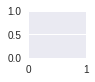

In [52]:
SpatialCorrAll(bba, 256)

In [26]:
PlotSpatialCorrAll(corr_patches_pn)

NameError: global name 'k' is not defined

In [ ]:
fig.subplots_adjust(hspace=0.1, left=0.1, right=0.7)
fig.show()

# Correlation tests along Galactic meridians and parallels:

In [53]:
start = -90
stop = 90
step = 1

glat_intervs = np.arange(start,stop,step)

start = 0
stop = 360
step = 1

glon_intervs = np.arange(start,stop,step)

glats = [np.where(np.logical_and(coords['glat']>i, coords['glat']< i+1))  for i in glat_intervs]

glons = [np.where(np.logical_and(coords['glon']>i, coords['glon']< i+1))  for i in glon_intervs]

In [54]:

bb_corr_glats = [bba.iloc[i].corr(method='spearman') for i in glats]

bb_corr_glons = [bba.iloc[i].corr(method='spearman') for i in glons]

#bb_corr_glats_A9 = [bb_corr_glats[i]['A9']]

bb_corr_glats_pn = pd.Panel({i: bb_corr_glats[i] for i in glat_intervs})
bb_corr_glons_pn = pd.Panel({i: bb_corr_glons[i] for i in glon_intervs})

In [55]:
planck_mw_corr_glats = [planck_mw.iloc[i].corr(method='spearman') for i in glats]

planck_mw_corr_glons = [planck_mw.iloc[i].corr(method='spearman') for i in glons]

#bb_corr_glats_A9 = [bb_corr_glats[i]['A9']]

planck_mw_corr_glats_pn = pd.Panel({i: planck_mw_corr_glats[i] for i in glat_intervs})
planck_mw_corr_glons_pn = pd.Panel({i: planck_mw_corr_glons[i] for i in glon_intervs})

In [56]:
bba.columns

Index([u'$T$', u'$B$', u'$R$', u'A9', u'AME'], dtype='object')

In [57]:
import matplotlib as mpl
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['figure.edgecolor'] = 'black'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

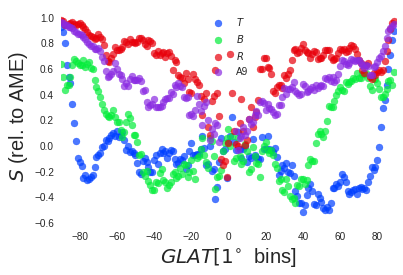

In [58]:
#plt.rcParams['axes.facecolor']='white'
#matplotlib.style.use('seaborn-bright')


X = glat_intervs

Y = bb_corr_glats_pn.values[:,:,4]

fig, ax = plt.subplots(edgecolor='k')

for i in range(0,4):
    ax.set_frame_on(True)
    ax.scatter(X,Y[:,i], alpha=0.7, label=bba.columns[i])
    ax.patch.set_visible(True) 
    ax.grid(True) 
    ax.set_frame_on(True)
    
    
legend = ax.legend(loc=0, shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.xlim(-90,90)
plt.ylabel("$S$ (rel. to AME)", fontsize=20)
plt.xlabel("$GLAT [1^{\circ}$  bins]", fontsize=20)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_byGLAT.pdf", 
            bbox_inches ='tight')



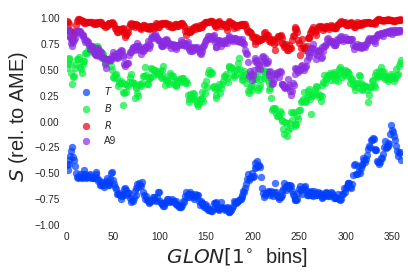

In [59]:
X = glon_intervs

Y = bb_corr_glons_pn.values[:,:,4]

fig, ax  = plt.subplots()

for i in range(0,4):
    ax.scatter(X,Y[:,i], alpha=0.7, label=bba.columns[i])
    
legend = ax.legend(loc=0, shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
#plt.legend(loc=1,prop={'size':14},fancybox=True, framealpha=1)
#leg.get_frame().set_alpha(0.5)
plt.xlim(0,360)
plt.ylabel("$S$ (rel. to AME)", fontsize=20)
plt.xlabel(" $GLON [1^{\circ}$  bins]", fontsize=20)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_byGLON.pdf", 
            bbox_inches ='tight',
            facecolor = fig.get_facecolor())
#plt.close()
# plt.hist(bb_corr_glats_pn.dropna().values[:,2,0], bins=10, alpha=0.4, label='Beta')
# plt.hist(bb_corr_glats_pn.dropna().values[:,3,0], bins=10, alpha=0.4, label='FIR')
# plt.hist(bb_corr_glats_pn.dropna().values[:,4,0], bins=10, alpha=0.4, label='A9')



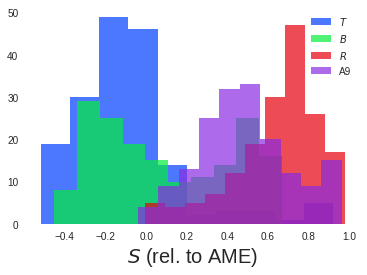

In [60]:
fig, ax = plt.subplots()

for i in range(0,4):
    ax.hist(bb_corr_glats_pn.dropna().values[:,i,4], alpha=0.7, label=bba.columns[i], bins=10)
ax.legend(loc=0)
plt.xlabel("$S$ (rel. to AME)", fontsize=20)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_GLAT_hist.pdf", bbox_inches='tight')

#plt.plot[bb_corr_glats_pn.values[]])

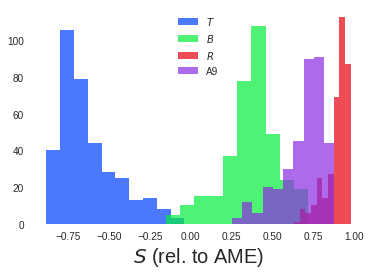

In [61]:
fig, ax = plt.subplots()

for i in range(0,4):
    ax.hist(bb_corr_glons_pn.dropna().values[:,i,4], alpha=0.7, label=bba.columns[i], bins=10)
ax.legend(loc=0)
plt.xlabel("$S$ (rel. to AME)", fontsize=20)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_GLON_hist.pdf", bbox_inches='tight')
#plt.close()

#plt.plot[bb_corr_glats_pn.values[]])

## AME to IR Ratio Averages:

In [62]:
## Just got the median intensities along GLON:
#### Using mode-subtracted maps

In [63]:

planck_mw_glons_med  = [planck_mw.iloc[i].dropna().median() for i in glons]
planck_mw_glats_med  = [planck_mw.iloc[i].dropna().median() for i in glats]
planck_mw_glons_mean = [planck_mw.iloc[i].dropna().mean() for i in glons]
planck_mw_glats_mean = [planck_mw.iloc[i].dropna().mean() for i in glats]


phot_glons_med = [phot.iloc[i].dropna().median() for i in glons]
phot_glats_med = [phot.iloc[i].dropna().median() for i in glats]
phot_glons_mean= [phot.iloc[i].dropna().mean() for i in glons]
phot_glats_mean = [phot.iloc[i].dropna().mean() for i in glats]


In [64]:
pd.DataFrame(phot_glons_med)[['A9','I12','A18','I25','I100','A140','P857']].join(pd.DataFrame(planck_mw_glons_med)['AME']) \
.plot(subplots=True,title="Med. Intensity Variation Along GLON")
plt.xlabel("$l$")
#plt.show()
plt.savefig("../Plots/IntensityByGLON_median.pdf", bbox_inches='tight')
plt.close()

pd.DataFrame(phot_glats_med)[['A9','I12','A18','I25','I100','A140','P857']].join(pd.DataFrame(planck_mw_glats_med)['AME']).set_index(glat_intervs) \
.plot(subplots=True,title="Med. Intensity Variation Along GLAT ")
plt.xlabel("$b$")
#plt.show()
plt.savefig("../Plots/IntensityByGLAT_median.pdf", bbox_inches='tight')
plt.close()

#Plot by Means:
pd.DataFrame(phot_glons_mean)[['A9','I12','A18','I25','I100','A140','P857']].join(pd.DataFrame(planck_mw_glons_mean)['AME']). \
plot(subplots=True,title="Mean Intensity Variation Along GLON")
plt.xlabel("$l$")
#plt.show()
plt.savefig("../Plots/IntensitybyGLON_mean.pdf", bbox_inches='tight')
plt.close()

pd.DataFrame(phot_glats_mean)[['A9','I12','A18','I25','I100','A140','P857']].join(pd.DataFrame(planck_mw_glats_mean)['AME']).set_index(glat_intervs) \
.plot(subplots=True,title="Mean Intensity Variation Along GLAT ")
plt.xlabel("$b$")
#plt.show()
plt.savefig("../Plots/IntensityByGLAT_mean.pdf", bbox_inches='tight')
plt.close()

In [65]:
# Get the COMMANDER Components along GLON and GLAT:

pd.DataFrame(planck_mw_glons_med).plot(subplots=True,title="Med. Intensity Variation Along GLON")
plt.xlabel("$l$")
#plt.show()
plt.savefig("../Plots/CommanderByGLON_median.pdf", bbox_inches='tight')
plt.close()

pd.DataFrame(planck_mw_glats_med).set_index(glat_intervs) \
.plot(subplots=True,title="Med. Intensity Variation Along GLAT ")
plt.xlabel("$b$")
#plt.show()
plt.savefig("../Plots/CommanderByGLAT_median.pdf", bbox_inches='tight')
plt.close()
######################
## By Mean:
pd.DataFrame(planck_mw_glons_mean).plot(subplots=True,title="Mean Intensity Variation Along GLON")
plt.xlabel("$l$")
#plt.show()
plt.savefig("../Plots/CommanderByGLON_mean.pdf", bbox_inches='tight')
plt.close()

pd.DataFrame(planck_mw_glats_mean).set_index(glat_intervs) \
.plot(subplots=True,title="Mean Intensity Variation Along GLAT ")
plt.xlabel("$b$")
#plt.show()
plt.savefig("../Plots/CommanderByGLAT_mean.pdf", bbox_inches='tight')
plt.close()

In [66]:
phot_AME_ratio = pd.DataFrame(
    
    (phot_tr.values.T/planck_mw_tr['AME'].values).T,
    columns = phot_tr.columns)

phot_AME_ratio.head()

phot_AME_ratio_glons_med = [phot_AME_ratio.iloc[i].median() for i in glons]
phot_AME_ratio_glats_med = [phot_AME_ratio.iloc[i].median() for i in glats]

phot_AME_ratio_glons_mean = [phot_AME_ratio.iloc[i].dropna().mean() for i in glons]
phot_AME_ratio_glats_mean = [phot_AME_ratio.iloc[i].dropna().mean() for i in glats]

planck_mw_glons_med_scaled  = [planck_mw_tr.iloc[i].dropna().median() for i in glons]
planck_mw_glats_med_scaled  = [planck_mw_tr.iloc[i].dropna().median() for i in glats]
planck_mw_glons_mean_scaled = [planck_mw_tr.iloc[i].dropna().mean() for i in glons]
planck_mw_glats_mean_scaled = [planck_mw_tr.iloc[i].dropna().mean() for i in glats]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


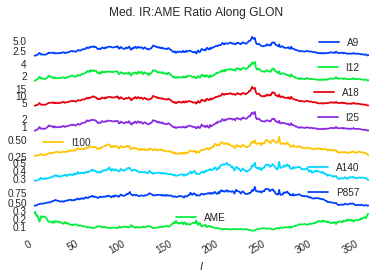

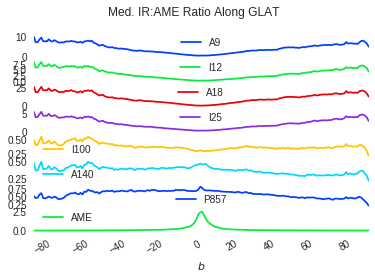

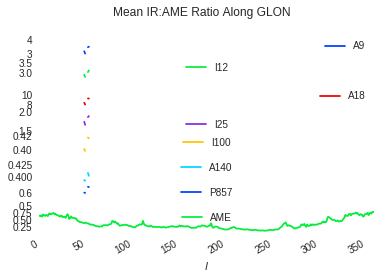

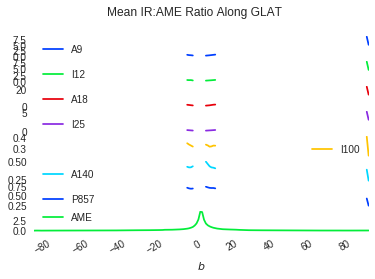

In [67]:
pd.DataFrame(phot_AME_ratio_glons_med)[['A9','I12','A18','I25','I100','A140','P857']].join(pd.DataFrame(planck_mw_glons_med_scaled)['AME']) \
.plot(subplots=True,title="Med. IR:AME Ratio Along GLON")
plt.xlabel("$l$")
plt.show()
plt.savefig("../Plots/Intensity_AME_ratio_ByGLON_median.pdf", bbox_inches='tight')
plt.close()

pd.DataFrame(phot_AME_ratio_glats_med)[['A9','I12','A18','I25','I100','A140','P857']].join(pd.DataFrame(planck_mw_glats_med_scaled)['AME']).set_index(glat_intervs) \
.plot(subplots=True,title="Med. IR:AME Ratio Along GLAT ")
plt.xlabel("$b$")
plt.show()
plt.savefig("../Plots/Intensity_AME_ratio_ByGLAT_median.pdf", bbox_inches='tight')
plt.close()

#Plot by Means:
pd.DataFrame(phot_AME_ratio_glons_mean)[['A9','I12','A18','I25','I100','A140','P857']].join(pd.DataFrame(planck_mw_glons_mean_scaled)['AME']). \
plot(subplots=True,title="Mean IR:AME Ratio Along GLON")
plt.xlabel("$l$")
plt.show()
plt.savefig("../Plots/Intensity_AME_ratio_byGLON_mean.pdf", bbox_inches='tight')
plt.close()

pd.DataFrame(phot_AME_ratio_glats_mean)[['A9','I12','A18','I25','I100','A140','P857']].join(pd.DataFrame(planck_mw_glats_mean_scaled)['AME']).set_index(glat_intervs) \
.plot(subplots=True,title="Mean IR:AME Ratio Along GLAT ")
plt.xlabel("$b$")
plt.show()
plt.savefig("../Plots/Intensity_AME_ratio_ByGLAT_mean.pdf", bbox_inches='tight')
plt.close()

# All-sky AME vs. IR plots:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


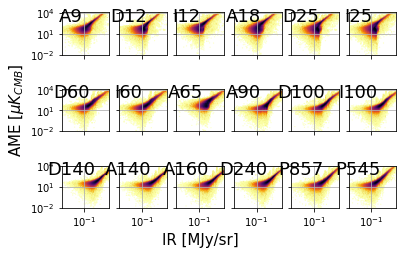

In [5]:
ncols=6
nrows=3
aspect=1.0

fig, axs = plt.subplots(ncols=ncols, 
                        nrows=nrows, 
                        sharey=True, 
                        sharex=True)
#fig.subplots_adjust(hspace=0.1, left=0.1, right=0.7)
plt.setp(axs.flat, aspect=1.0, adjustable='box-forced')

k=0


for i in range(0,nrows):
    for j in range(0,ncols):
            
            if k > 17:
                
                pass
            
            else:
           
                x = phot_modesub.values[:,k]


                y = planck_mw['AME'].values[:]

                x_ = x[(x>0) & (y>0)]
                y_ = y[(x>0) & (y>0)]


                xmin = 5e-5#x_.min()
                xmax = 400 #x_.max()
                ymin = 0.01#y_.min()
                ymax = y_.max()

                ax = axs[i,j]
                #ax.set_aspect(aspect, adjustable='box')

                hb = ax.hexbin(
                       x_,
                       y_, 
                       mincnt=1,
                       gridsize=300,
                       bins='log', 
                       cmap='inferno_r',
                       xscale='log',
                       yscale='log')


                ax.axis([xmin, xmax, ymin, ymax])

                ax.text(0.2, 0.9,phot_modesub.columns[k], horizontalalignment='center',
                  verticalalignment='center',
                  transform=ax.transAxes, 
                  fontsize=15)
                
                ax.grid(True)
                
                ax.set_frame_on(True)

                k += 1
            
ax = axs[1,0]
ax.set_ylabel('AME [$\mu{}K_{CMB}$]', fontsize=15)
ax = axs[-1,2]
ax.set_xlabel('IR [MJy/sr]', fontsize=15)

plt.show()

fig.savefig("../Plots/AMEvsDust_allsky_allbands.pdf", bbox_inches='tight')  


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


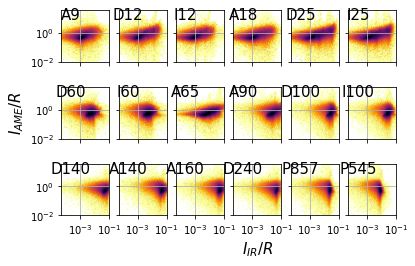

In [10]:
ncols=6
nrows=3
aspect=1.0

fig, axs = plt.subplots(ncols=ncols, 
                        nrows=nrows, 
                        sharey=True, 
                        sharex=True)
#fig.subplots_adjust(hspace=0.1, left=0.1, right=0.7)
plt.setp(axs.flat, aspect=1.0, adjustable='box-forced')

k=0


for i in range(0,nrows):
    for j in range(0,ncols):
            
            if k > 17:
                
                pass
            
            else:
           
                x = phot_modesub.values[:,k]


                y = planck_mw['AME'].values[:]
                
                R = planck_bb['$R$'].values[:]
                
                y = y/R
                x = x/R

                x_ = x[(x>0) & (y>0)]
                y_ = y[(x>0) & (y>0)]


                xmin = 5e-5#x_.min()
                xmax = 0.1 #x_.max()
                ymin = 0.01#y_.min()
                ymax = y_.max()

                ax = axs[i,j]
                #ax.set_aspect(aspect, adjustable='box')

                hb = ax.hexbin(
                       x_,
                       y_, 
                       mincnt=1,
                       gridsize=300,
                       bins='log', 
                       cmap='inferno_r',
                       xscale='log',
                       yscale='log')


                ax.axis([xmin, xmax, ymin, ymax])

                ax.text(0.2, 0.9,phot_modesub.columns[k], horizontalalignment='center',
                  verticalalignment='center',
                  transform=ax.transAxes, 
                  fontsize=15)
                
                ax.grid(True)
                
                ax.set_frame_on(True)

                k += 1
            
ax = axs[1,0]
ax.set_ylabel('$I_{AME} / R$', fontsize=15)
ax = axs[-1,3]
ax.set_xlabel('$I_{IR} / R$', fontsize=15)

plt.show()

fig.savefig("../Plots/AMEtoRvsDusttoR_allsky_allbands.pdf", bbox_inches='tight')  


# Angular Power Spectra:

In [ ]:
plt.loglog(hp.anafast(planck_mw['AME'].values))

In [ ]:
phot_unseens = phot.replace(
    to_replace =np.nan,
    value=hp.UNSEEN
    )

fig = plt.figure(figsize=(8,8))

plt.loglog(hp.anafast(phot_unseens['A9'].values), label="A9")
plt.loglog(hp.anafast(phot_unseens['I12'].values), label="I12")
plt.loglog(hp.anafast(phot_unseens['I60'].values), label="I100")
plt.loglog(hp.anafast(phot_unseens['A140'].values), label="A140")
plt.loglog(hp.anafast(phot_unseens['P545'].values), label="P857")

plt.loglog(hp.anafast(planck_mw['AME'].values), label="AME")

plt.title("Angular Power Spectra of AME and various IR bands", fontsize=20)
plt.xlabel("$l$", fontsize=20)
plt.ylabel("$Cl$",fontsize=20)




plt.legend()

fig.savefig("../Plots/AngPowerSpec_AMEandIR.pdf", bbox_inches='tight')

In [ ]:
a140 = phot['A140'].replace(
    to_replace =np.nan,
    value=hp.UNSEEN
    ).values

hp.anafast(a140)

In [ ]:
# For each pixel in map, query_disc a 5 degree ring of pixels
    # Take the spearman correlation coefficient of that ring of pixels
    # Set that pixel value to the spearman correlation coefficient


In [74]:
import time

from sklearn.manifold import TSNE

rndperm = np.random.permutation(phot.shape[0])

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(phot_tr.loc[rndperm[:n_sne],:].values)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.026871
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.351604
[t-SNE] Error after 300 iterations: 1.351604
t-SNE done! Time elapsed: 84.7215769291 seconds


In [85]:
phot_tr_tsne.head()

,A9,D12,I12,A18,D25,I25,D60,I60,A65,A90,D100,I100,D140,A140,A160,D240,P857,P545,x-tsne,y-tsne
484350,1.269954,2.327405,1.465967,1.727320,1.230796,0.773489,1.022693,0.609266,0.574586,1.091397,1.654193,1.246481,2.185365,1.903700,1.969042,3.018372,3.301473,3.988673,1.937721,-11.708283
692606,0.309571,0.343759,0.225544,0.839080,0.286246,0.138243,0.025771,0.017351,0.034518,0.029975,0.043396,0.038295,0.043965,0.029870,0.028486,0.041218,0.060306,0.074838,0.193500,3.476091
636356,0.294280,0.376855,0.248196,0.777372,0.307520,0.143525,0.031235,0.020030,0.026310,0.039989,0.049928,0.040132,0.050954,0.037509,0.029541,0.073913,0.069741,0.084281,-1.861145,2.260605
691200,0.344304,0.405273,0.252588,0.818833,0.329805,0.158269,0.025388,0.015575,0.039700,0.033390,0.044663,0.035353,0.040333,0.033429,0.043937,0.027941,0.055609,0.068443,-1.664505,2.104742
705699,0.269166,0.284337,0.181214,0.724427,0.242164,0.119764,0.015534,0.009250,0.024716,0.013684,0.021168,0.016316,0.031280,0.014147,0.020610,0.026490,0.024610,0.034257,3.780309,-1.829610


In [75]:
phot_tr_tsne = phot_tr.loc[rndperm[:n_sne],:].copy()
phot_tr_tsne['x-tsne'] = tsne_results[:,0]
phot_tr_tsne['y-tsne'] = tsne_results[:,1]


In [78]:
from ggplot import *

In [93]:
chart = ggplot( phot_tr_tsne, aes(x='x-tsne', y='y-tsne')) \
        + geom_point(size=70, alpha = 0.1) \
        + ggtitle("tSNE dimensions colored by digit")

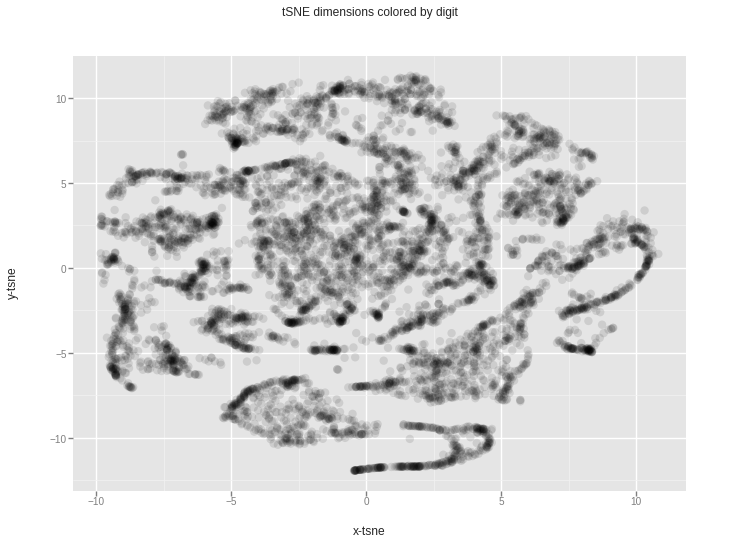

<ggplot: (8786127479269)>

In [94]:
chart

In [105]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_result = pca.fit_transform(phot_tr.values)
phot_tr_pca = phot_tr.copy()

phot_tr_pca['pca-one'] = pca_result[:,0]
phot_tr_pca['pca-two'] = pca_result[:,1]
#phot_tr_pca['pca-three'] = pca_result[:,2]


print "Explained variation per principal component:{}".format(pca.explained_variance_ratio_)


Explained variation per principal component:[ 0.75930168  0.10001218]


In [106]:
chart_pca = ggplot(phot_tr_pca.loc[:,:], aes(x='pca-one',y='pca-two') ) \
        + geom_point(size=75, alpha=0.2) \
        + ggtitle("First and Second Principal Components colored by digit")

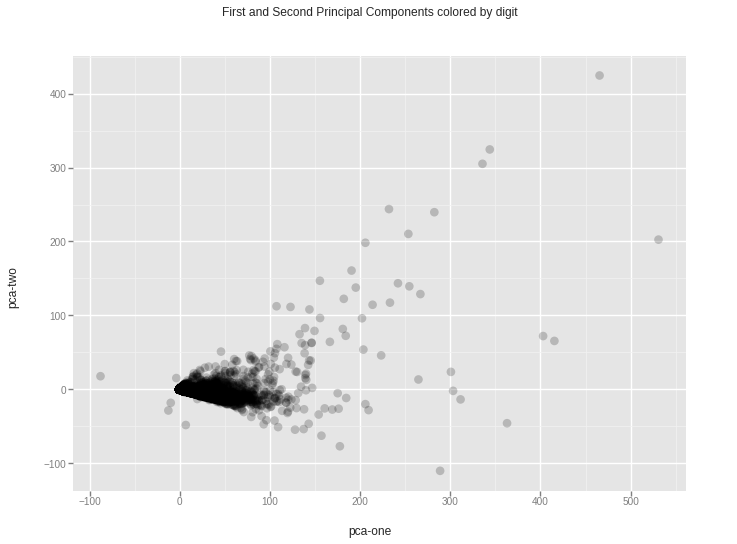

<ggplot: (8786127375697)>

In [107]:
chart_pca

In [113]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2)

nmf_result = nmf.fit_transform(phot_tr.values)
phot_tr_nmf = phot_tr.copy()

phot_tr_nmf['nmf-one'] = nmf_result[:,0]
phot_tr_nmf['nmf-two'] = nmf_result[:,1]
#phot_tr_pca['pca-three'] = pca_result[:,2]


print "Explained variation per principal component:{}".format(nmf.explained_variance_ratio_)


ValueError: Negative values in data passed to NMF (input X)